In [ ]:
# you need inst_h_d and instagram.csv to fully use this notebook

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from scipy.stats import kruskal
import scikit_posthocs as sp
import pprint
from load_inst import *
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
register_matplotlib_converters()
plt.rcParams.update({'figure.max_open_warning': 0})

# Basic analysis

In [ ]:
instagram = load_instagram() # use this line if you want load whole data

In [ ]:
instagram.head(5)

In [ ]:
len(instagram.ID.unique())

In [ ]:
plt.figure(figsize=(30,20))
sns.lineplot(data=instagram, x='Time', y='Likes', hue='ID')

In [ ]:
get_rows = rows_choose(days=range(1,31))
inst_h_d = get_rows.transform(instagram) # do not use unless you have updated the data or you want to
                                         # get different timeshifts, it takes a lot of time to compute
with open('inst_h_d', 'wb') as save_pickle:
    pickle.dump(inst_h_d, save_pickle)

In [ ]:
with open('inst_h_d', 'rb') as tmp_pickle: # line to load data frame with default time shifts
    inst_h_d = pickle.load(tmp_pickle)

In [ ]:
inst_h_d.loc['1h'].head(5)

In [ ]:
dividing_point = (4, 7, 10, 16)
# default pipeline, it adds two columns - hours of first appereance as integers (it first rounds
# that time to full hours) and intervals of the time of first appereance
inst_h_d_pipe = Pipeline([('hours_to_int', get_hours()),
                          ('hours_intervals', hours_interval(dividing_points=dividing_point))])
inst_h_d_to_use = inst_h_d_pipe.fit_transform(inst_h_d)
inst_h_d_to_use.loc['1h']

## Plots

In [ ]:
my_order = create_time_intervals(dividing_point)
time_shift_h_list = ['%sh' %num for num in range(1,24,1)]
hours_names = ['1 hour']
hours_names.extend(['%s hours' %num for num in range(2,24,1)])
time_shift_d_list = ['%sd' %num for num in range(1,31,1)]
days_names = ['1 day']
days_names.extend(['%s days' %num for num in range(2,31,1)])

In [ ]:
for time_shift, m_hours in zip(time_shift_h_list, hours_names):
    plt.figure(figsize=(10,15))
    sns.boxplot(x="Time_intervals", y="Likes", data=inst_h_d_to_use.loc[time_shift],  order=my_order)
    sns.stripplot(x="Time_intervals", y="Likes", data=inst_h_d_to_use.loc[time_shift], jitter=True,
                  color='black', order=my_order).set(title='Likes after '+m_hours, xlabel='Time intervals')
        

In [ ]:
plt.figure(figsize=(15, 10))
sns.regplot(x='Int_hour', y='Likes', data=inst_h_d_to_use.loc['1h'], color='black', label='1h', x_jitter=0.2, fit_reg=True)
sns.regplot(x='Int_hour', y='Likes', data=inst_h_d_to_use.loc['6h'], color='red', label='6h', x_jitter=0.2,fit_reg=True)
sns.regplot(x='Int_hour', y='Likes', data=inst_h_d_to_use.loc['12h'], color='blue', label='12h', x_jitter=0.2, fit_reg=True)
plt.legend();

In [ ]:
for time_shift, m_day in zip(time_shift_d_list, days_names):
    plt.figure(figsize=(10,15))
    sns.boxplot(x="Time_intervals", y="Likes", data=inst_h_d_to_use.loc[time_shift],  order=my_order)
    sns.stripplot(x="Time_intervals", y="Likes", data=inst_h_d_to_use.loc[time_shift], jitter=True,
                  color='black', order=my_order).set(title='Likes after '+m_day, xlabel='Time intervals')

In [ ]:
plt.figure(figsize=(15, 10))
sns.regplot(x='Int_hour', y='Likes', data=inst_h_d_to_use.loc['1d'], color='black', label='1d', x_jitter=0.2, fit_reg=True)
sns.regplot(x='Int_hour', y='Likes', data=inst_h_d_to_use.loc['6d'], color='red', label='6d', x_jitter=0.2,fit_reg=True)
sns.regplot(x='Int_hour', y='Likes', data=inst_h_d_to_use.loc['12d'], color='blue', label='12d', x_jitter=0.2, fit_reg=True)
plt.legend();

## Statistics

In [ ]:
inst_h_d_to_use.loc['1h'][['Likes', 'Time_intervals']].groupby(['Time_intervals']).describe()

In [ ]:
inst_h_d_to_use.loc['6h'][['Likes', 'Time_intervals']].groupby(['Time_intervals']).describe()

In [ ]:
inst_h_d_to_use.loc['12h'][['Likes', 'Time_intervals']].groupby(['Time_intervals']).describe()

In [ ]:
inst_h_d_to_use.loc['1d'][['Likes', 'Time_intervals']].groupby(['Time_intervals']).describe()

In [ ]:
inst_h_d_to_use.loc['6d'][['Likes', 'Time_intervals']].groupby(['Time_intervals']).describe()

In [ ]:
inst_h_d_to_use.loc['12d'][['Likes', 'Time_intervals']].groupby(['Time_intervals']).describe()

### Correlation

In [ ]:
ind_names = ('1h', '6h', '12h', '1d', '6d', '12d')
corr_dict = {'%s' %ind :inst_h_d_to_use.loc[ind]['Likes'].corr(inst_h_d_to_use.loc[ind]['Int_hour']) for ind in ind_names}
for name, corr in corr_dict.items():
    print('%s: %s\n' %(name, corr))

## Tests

In [ ]:
kruskal(*[group["Likes"].values for _, group in inst_h_d_to_use.loc['1h'][['Likes', 'Time_intervals']].groupby(['Time_intervals'])])

In [ ]:
kruskal(*[group["Likes"].values for _, group in inst_h_d_to_use.loc['6h'][['Likes', 'Time_intervals']].groupby(['Time_intervals'])])

In [ ]:
kruskal(*[group["Likes"].values for _, group in inst_h_d_to_use.loc['12h'][['Likes', 'Time_intervals']].groupby(['Time_intervals'])])

In [ ]:
sp.posthoc_dunn(inst_h_d_to_use.loc['12h'][['Likes', 'Time_intervals']], val_col='Likes', group_col='Time_intervals', p_adjust = 'holm')

In [ ]:
kruskal(*[group["Likes"].values for _, group in inst_h_d_to_use.loc['1d'][['Likes', 'Time_intervals']].groupby(['Time_intervals'])])

In [ ]:
kruskal(*[group["Likes"].values for _, group in inst_h_d_to_use.loc['6d'][['Likes', 'Time_intervals']].groupby(['Time_intervals'])])

In [ ]:
kruskal(*[group["Likes"].values for _, group in inst_h_d_to_use.loc['12d'][['Likes', 'Time_intervals']].groupby(['Time_intervals'])])

In [ ]:
kruskal(*[group["Likes"].values for _, group in inst_h_d_to_use.loc['12d'][['Likes', 'Time_intervals']].groupby(['Time_intervals'])])

## Number of likes in time intervals

### Each photo as single observation

In [ ]:
diff_pipe = Pipeline([('diff_maker', select_by_time(time_freq='3h')),
                      ('add_intervals', hours_interval(dividing_points=range(0, 25, 3),
                                                       low_int=True, int_time_col='Time',
                                                       full_day=True))])
inst_diff_likes = diff_pipe.transform(instagram)

In [ ]:
inst_no0_diff_likes = inst_diff_likes.loc[inst_diff_likes.Diff_likes != 0]

#### Plots

In [ ]:
plt.figure(figsize=(15,15))
sns.boxplot(x="Time_intervals", y="Diff_likes", data=inst_diff_likes)
sns.stripplot(x="Time_intervals", y="Diff_likes", data=inst_diff_likes, jitter=True,
              color='black');

In [ ]:
plt.figure(figsize=(15,15))
sns.boxplot(x="Time_intervals", y="Diff_likes", data=inst_no0_diff_likes)
sns.stripplot(x="Time_intervals", y="Diff_likes", data=inst_no0_diff_likes, jitter=True,
              color='black');

In [ ]:
time_int_hist = inst_no0_diff_likes.Time_intervals.unique()
for time_int in time_int_hist:
    plt.figure(figsize=(10,5))
    sns.distplot(inst_diff_likes.loc[inst_diff_likes.Time_intervals == time_int]['Diff_likes'],
                 color="black").set_title(time_int);

In [ ]:
for time_int in time_int_hist:
    plt.figure(figsize=(10,5))
    sns.distplot(inst_no0_diff_likes.loc[inst_no0_diff_likes.Time_intervals == time_int]['Diff_likes'],
                 color="black").set_title(time_int);

#### Statistics

In [ ]:
inst_diff_likes[['Diff_likes', 'Time_intervals']].groupby(['Time_intervals'], sort=False).describe()

In [ ]:
inst_no0_diff_likes[['Diff_likes', 'Time_intervals']].groupby(['Time_intervals'], sort=False).describe()

#### Tests

In [ ]:
kruskal(*[group["Diff_likes"].values for _, group in inst_diff_likes[['Diff_likes', 'Time_intervals']].groupby(['Time_intervals'])])

In [ ]:
time_int_photo_ph = sp.posthoc_dunn(inst_diff_likes[['Diff_likes', 'Time_intervals']], val_col='Diff_likes',
                group_col='Time_intervals',
                p_adjust='holm-sidak').replace(-1,1)
reindex_ph(time_int_photo_ph).style.background_gradient(cmap='coolwarm_r')

In [ ]:
kruskal(*[group["Diff_likes"].values for _, group in inst_no0_diff_likes[['Diff_likes', 'Time_intervals']].groupby(['Time_intervals'])])

In [ ]:
time_int_photo_ph_no0 = sp.posthoc_dunn(inst_no0_diff_likes[['Diff_likes', 'Time_intervals']], val_col='Diff_likes',
                group_col='Time_intervals',
                p_adjust='holm-sidak').replace(-1,1)
reindex_ph(time_int_photo_ph_no0).style.background_gradient(cmap='coolwarm_r')

### Each day as single observation

#### Plots

In [ ]:
diff_group_pipe = Pipeline([('diff_maker', select_by_time(time_freq='3h')),
                            ('add_intervals', hours_interval(dividing_points=range(0, 25, 3),
                                                             low_int=True, int_time_col='Time', full_day=True)),
                            ('group_int', group_by_days())])
inst_int_group_likes = diff_group_pipe.transform(instagram)
inst_int_no0_group_likes = inst_int_group_likes.loc[inst_int_group_likes['Diff_likes'] != 0]

In [ ]:
plt.figure(figsize=(15,15))
sns.boxplot(x="Time_intervals", y="Diff_likes", data=inst_int_group_likes);
sns.stripplot(x="Time_intervals", y="Diff_likes", data=inst_int_group_likes, jitter=True, color='black');

In [ ]:
plt.figure(figsize=(15,15))
sns.boxplot(x="Time_intervals", y="Diff_likes", data=inst_int_no0_group_likes);
sns.stripplot(x="Time_intervals", y="Diff_likes", data=inst_int_no0_group_likes, jitter=True, color='black');

In [ ]:
time_int_hist = inst_int_no_out_group_likes.Time_intervals.unique()
for time_int in time_int_hist:
    plt.figure(figsize=(10,5))
    sns.distplot(inst_int_group_likes.loc[inst_int_group_likes.Time_intervals == time_int]['Diff_likes'],
                 color="black").set_title(time_int);

In [ ]:
for time_int in time_int_hist:
    plt.figure(figsize=(10,5))
    sns.distplot(inst_int_no0_group_likes.loc[inst_int_no0_group_likes.Time_intervals == time_int]['Diff_likes'],
                 color="black").set_title(time_int);

#### Statistics

In [ ]:
inst_int_group_likes.groupby('Time_intervals', sort=False).describe()

In [ ]:
inst_int_no0_group_likes.groupby('Time_intervals', sort=False).describe()

#### Tests

In [ ]:
kruskal(*[group["Diff_likes"].values for _, group in inst_int_group_likes[['Diff_likes', 'Time_intervals']].groupby(['Time_intervals'])])

In [ ]:
time_int_day_ph = sp.posthoc_dunn(inst_int_group_likes[['Diff_likes', 'Time_intervals']], val_col='Diff_likes',
                group_col='Time_intervals',
                p_adjust='holm-sidak').replace(-1,1)
reindex_ph(time_int_day_ph).style.background_gradient(cmap='coolwarm_r')

In [ ]:
kruskal(*[group["Diff_likes"].values for _, group in inst_int_no0_group_likes[['Diff_likes', 'Time_intervals']].groupby(['Time_intervals'])])

In [ ]:
time_int_day_ph_no0 = sp.posthoc_dunn(inst_int_no0_group_likes[['Diff_likes', 'Time_intervals']], val_col='Diff_likes',
                group_col='Time_intervals',
                p_adjust='holm-sidak').replace(-1,1)
reindex_ph(time_int_day_ph_no0).style.background_gradient(cmap='coolwarm_r')

# Days of week

## Days general

### Each photo as single observation

In [18]:
time_days_likes_diff_day_group = Pipeline([('Time_select', select_by_time(time_freq='1D')),
                                 ('Day_of_week',get_day_of_week(prev_day=True, sort_by_num=True)),
                                 ('Day_of_week_f_app',get_day_of_week(prev_day=False, time_col='First_app',
                                                                     day_col_name='Day_of_first_app', 
                                                                     day_col_num='Day_of_first_app_num',
                                                                     sort_by_num=False))])
photo_day_diff_likes = time_days_likes_diff_day_group.transform(instagram)

In [24]:
photo_day_diff_likes_no0 = photo_day_diff_likes.loc[photo_day_diff_likes.Diff_likes != 0]
photo_day_diff_likes_no_out = photo_day_diff_likes_no0[photo_day_diff_likes_no0.Diff_likes < 80]

In [25]:
hue_order_days = photo_day_diff_likes.Day_of_week.unique()

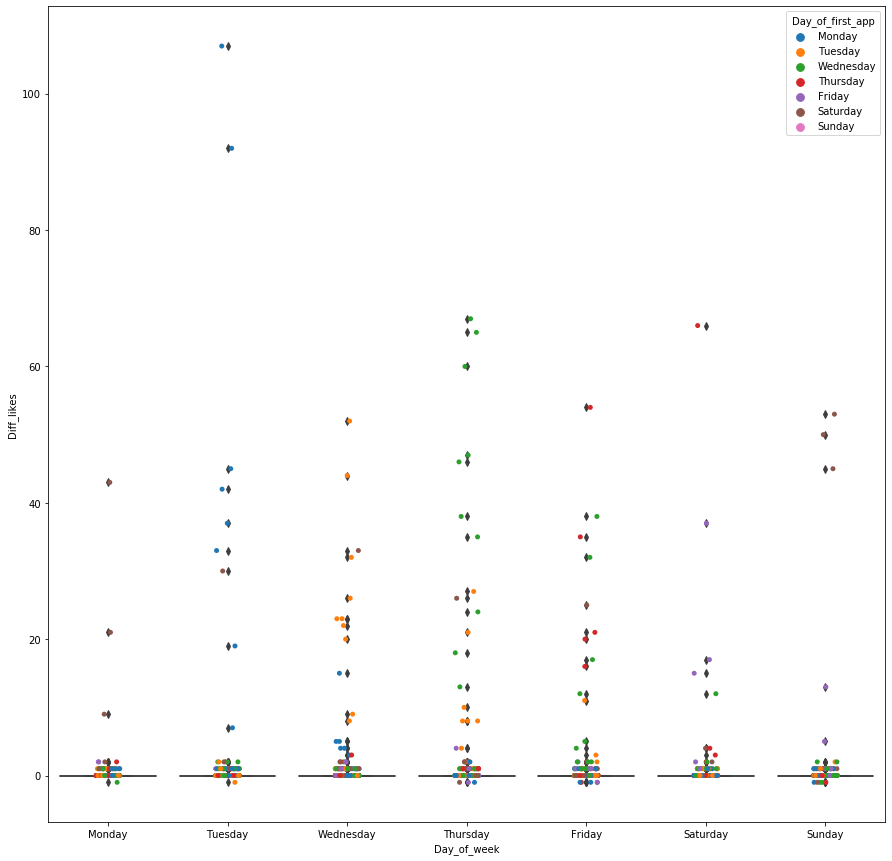

In [26]:
plt.figure(figsize=(15,15))
sns.boxplot(x="Day_of_week", y="Diff_likes", data=photo_day_diff_likes);
sns.stripplot(x="Day_of_week", y="Diff_likes", data=photo_day_diff_likes, jitter=True, hue='Day_of_first_app', 
              hue_order = hue_order_days);

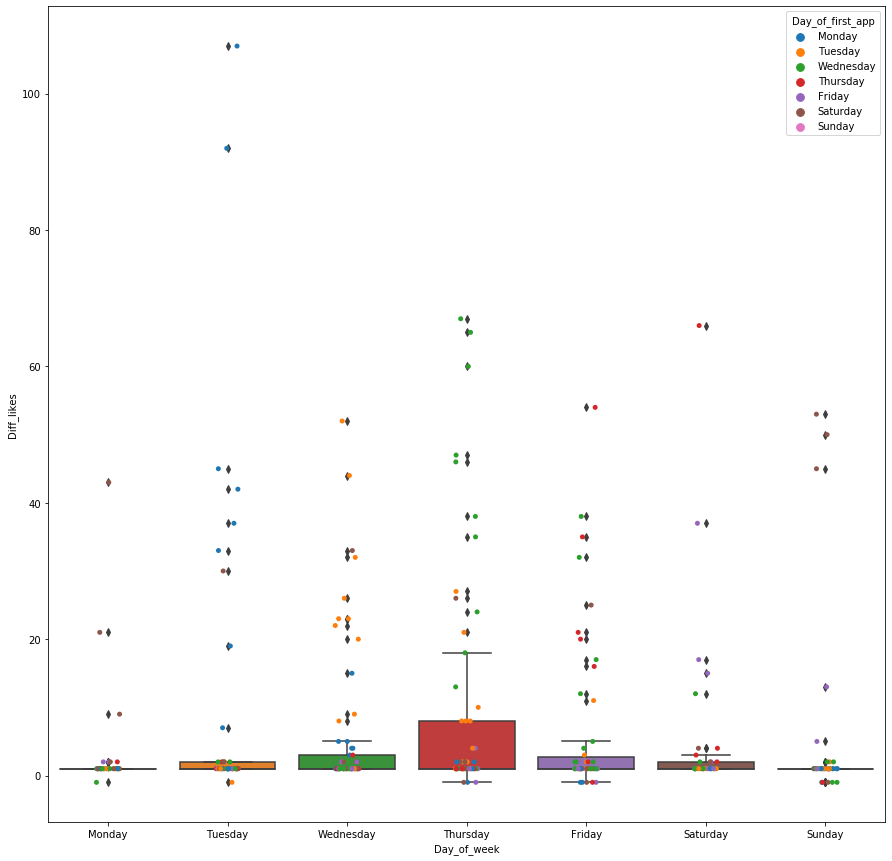

In [27]:
plt.figure(figsize=(15,15))
sns.boxplot(x="Day_of_week", y="Diff_likes", data=photo_day_diff_likes_no0);
sns.stripplot(x="Day_of_week", y="Diff_likes", data=photo_day_diff_likes_no0, jitter=True, hue='Day_of_first_app', 
              hue_order = hue_order_days);

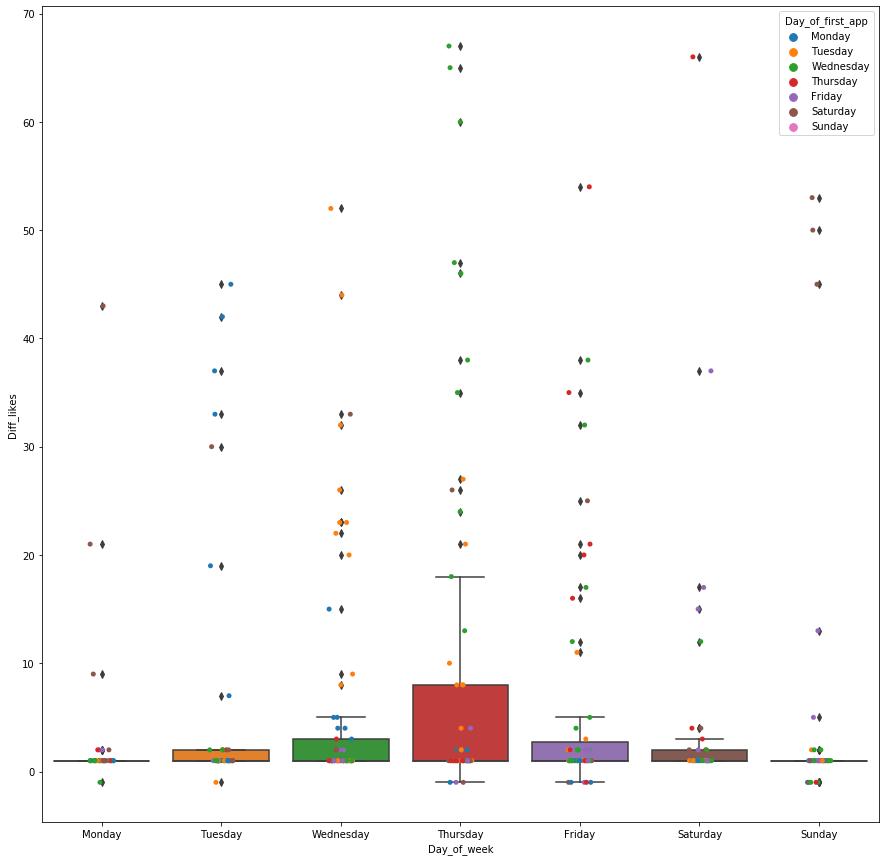

In [28]:
plt.figure(figsize=(15,15))
sns.boxplot(x="Day_of_week", y="Diff_likes", data=photo_day_diff_likes_no_out);
sns.stripplot(x="Day_of_week", y="Diff_likes", data=photo_day_diff_likes_no_out, jitter=True, hue='Day_of_first_app', 
              hue_order = hue_order_days);

In [10]:
photo_day_diff_likes[['Diff_likes', 'Day_of_week']].groupby('Day_of_week', sort=False).describe()

Diff_likes                                               
                 count      mean       std  min  25%  50%  75%    max
Day_of_week                                                          
Monday           370.0  0.302703  2.542909 -1.0  0.0  0.0  0.0   43.0
Tuesday          368.0  1.244565  8.570908 -1.0  0.0  0.0  0.0  107.0
Wednesday        369.0  1.048780  5.081168  0.0  0.0  0.0  0.0   52.0
Thursday         372.0  1.540323  7.652915 -1.0  0.0  0.0  0.0   67.0
Friday           357.0  0.924370  4.940931 -1.0  0.0  0.0  0.0   54.0
Saturday         374.0  0.510695  4.131698  0.0  0.0  0.0  0.0   66.0
Sunday           378.0  0.518519  4.452034 -1.0  0.0  0.0  0.0   53.0

In [11]:
photo_day_diff_likes_no0[['Diff_likes', 'Day_of_week']].groupby('Day_of_week', sort=False).describe()

Diff_likes                                                 
                 count      mean        std  min  25%  50%   75%    max
Day_of_week                                                            
Monday            40.0  2.800000   7.349167 -1.0  1.0  1.0  1.00   43.0
Tuesday           51.0  8.980392  21.641155 -1.0  1.0  1.0  2.00  107.0
Wednesday         69.0  5.608696  10.666354  1.0  1.0  1.0  3.00   52.0
Thursday          62.0  9.241935  16.848102 -1.0  1.0  1.0  8.00   67.0
Friday            54.0  6.111111  11.475432 -1.0  1.0  1.0  2.75   54.0
Saturday          37.0  5.162162  12.336742  1.0  1.0  1.0  2.00   66.0
Sunday            42.0  4.666667  12.744519 -1.0  1.0  1.0  1.00   53.0

In [29]:
photo_day_diff_likes_no_out[['Diff_likes', 'Day_of_week']].groupby('Day_of_week', sort=False).describe()

Diff_likes                                                
                 count      mean        std  min  25%  50%   75%   max
Day_of_week                                                           
Monday            40.0  2.800000   7.349167 -1.0  1.0  1.0  1.00  43.0
Tuesday           49.0  5.285714  11.409061 -1.0  1.0  1.0  2.00  45.0
Wednesday         69.0  5.608696  10.666354  1.0  1.0  1.0  3.00  52.0
Thursday          62.0  9.241935  16.848102 -1.0  1.0  1.0  8.00  67.0
Friday            54.0  6.111111  11.475432 -1.0  1.0  1.0  2.75  54.0
Saturday          37.0  5.162162  12.336742  1.0  1.0  1.0  2.00  66.0
Sunday            42.0  4.666667  12.744519 -1.0  1.0  1.0  1.00  53.0

### Each day as single observation

In [13]:
time_days_likes_diff_ID_group = Pipeline([('Time_select', select_by_time(time_freq='1D')),
                                 ('Day_of_week',get_day_of_week(prev_day=True)),
                                 ('Group_by_days_ID', group_by_days(time_int_col='Day_of_week'))])
photo_day_ID_diff_likes = time_days_likes_diff_ID_group.transform(instagram)

In [14]:
photo_day_ID_diff_likes_no0 = photo_day_ID_diff_likes.loc[photo_day_ID_diff_likes.Diff_likes != 0]

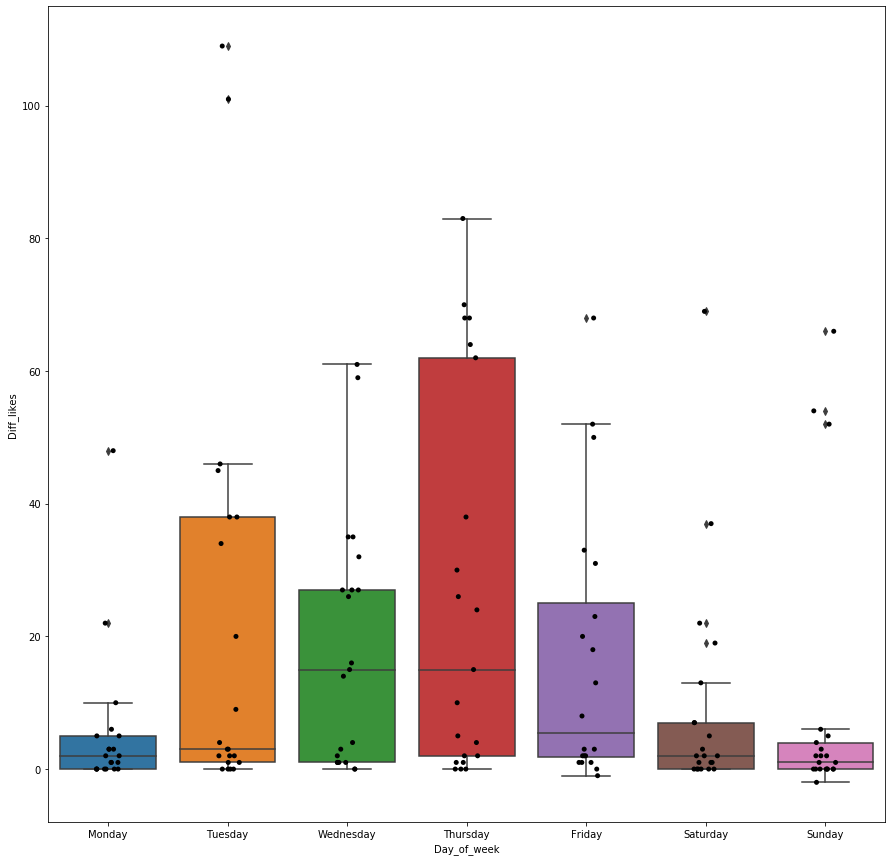

In [60]:
plt.figure(figsize=(15,15))
sns.boxplot(x="Day_of_week", y="Diff_likes", data=photo_day_ID_diff_likes);
sns.stripplot(x="Day_of_week", y="Diff_likes", data=photo_day_ID_diff_likes, jitter=True, color='black');

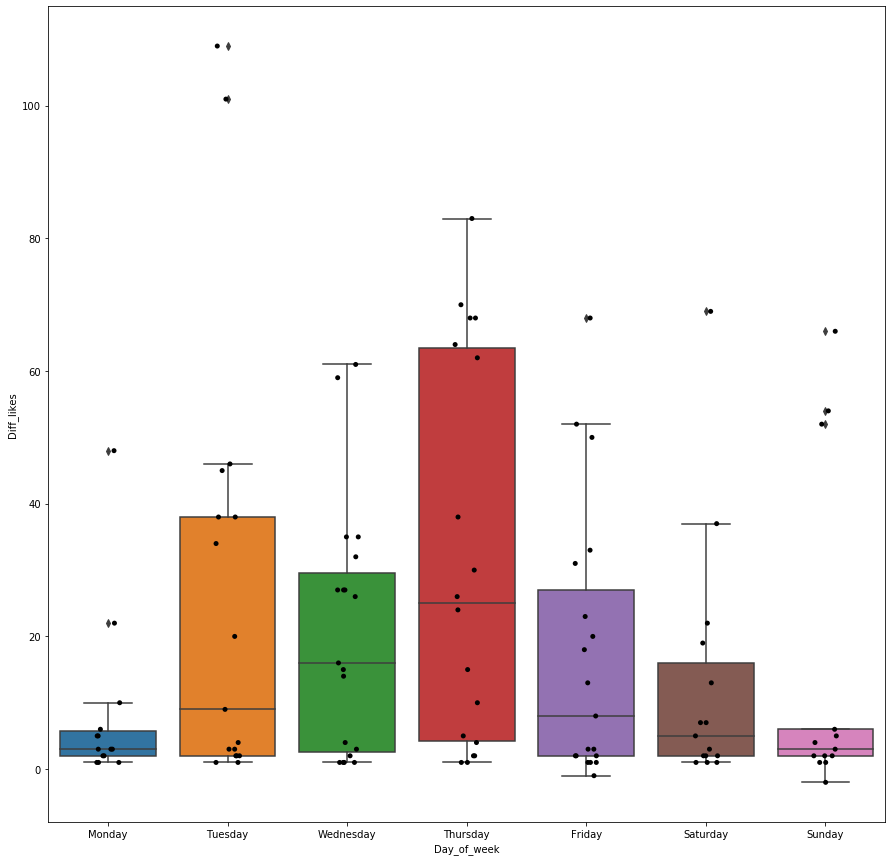

In [61]:
plt.figure(figsize=(15,15))
sns.boxplot(x="Day_of_week", y="Diff_likes", data=photo_day_ID_diff_likes_no0);
sns.stripplot(x="Day_of_week", y="Diff_likes", data=photo_day_ID_diff_likes_no0, jitter=True, color='black');

In [18]:
photo_day_ID_diff_likes.groupby('Day_of_week', sort=False).describe()

Diff_likes                                                    
                 count       mean        std  min   25%   50%   75%    max
Day_of_week                                                               
Monday            21.0   5.333333  10.987872  0.0  0.00   2.0   5.0   48.0
Tuesday           21.0  21.809524  32.254642  0.0  1.00   3.0  38.0  109.0
Wednesday         21.0  18.428571  18.864176  0.0  1.00  15.0  27.0   61.0
Thursday          21.0  27.285714  29.423023  0.0  2.00  15.0  62.0   83.0
Friday            20.0  16.500000  20.459202 -1.0  1.75   5.5  25.0   68.0
Saturday          21.0   9.095238  16.664047  0.0  0.00   2.0   7.0   69.0
Sunday            21.0   9.333333  20.310917 -2.0  0.00   1.0   4.0   66.0

In [19]:
photo_day_ID_diff_likes_no0.groupby('Day_of_week', sort=False).describe()

Diff_likes                                                     
                 count       mean        std  min   25%   50%    75%    max
Day_of_week                                                                
Monday            14.0   8.000000  12.758105  1.0  2.00   3.0   5.75   48.0
Tuesday           17.0  26.941176  33.964081  1.0  2.00   9.0  38.00  109.0
Wednesday         19.0  20.368421  18.806649  1.0  2.50  16.0  29.50   61.0
Thursday          18.0  31.833333  29.414382  1.0  4.25  25.0  63.50   83.0
Friday            19.0  17.368421  20.637642 -1.0  2.00   8.0  27.00   68.0
Saturday          15.0  12.733333  18.629725  1.0  2.00   5.0  16.00   69.0
Sunday            13.0  15.076923  24.366854 -2.0  2.00   3.0   6.00   66.0